# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


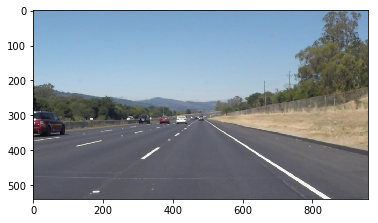

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def is_lane(line, slope_low, slope_high):
    """
    Arg:
    [Input]: 
        line: A single lane (output from cv.HoughLinesP)
        slope_low: slope low threshold
        slope_high: slope high threshold
        
    [Return]:
        bool: True (Belong to the specific cetogory of lane)
    
    Here the assumption is: the left or right lanes has the same slope at each section of lane.
    Short-comming: The curvature sceanrio
    """
    res = False
    
    # Extract points x1,y1,x2,y2 in HoughLineP
    x1 = line[0][0]
    y1 = line[0][1]
    x2 = line[0][2]
    y2 = line[0][3]
    
    if(x2-x1 != 0):
        m = (y2-y1)/(x2-x1)
        if(m > slope_low and m < slope_high):
            res = True

    return res
    
def extract_top_n_bottom_point(lines):
    """
    Arg:
    [Input]:
        lines: Either left or right lane
        
    [Output]:
        top_point, bottom_point: From either left or right lane.
    
    Based on the input lines, extract the most upper point and the most bottom point
    Here the assumption is: the left or right lanes has the same slope at each section of lane.
    Short-comming: The curvature sceanrio
    """
    bottom_point = (lines[0][0][0], lines[0][0][1])  # Init with (x1,y1)
    top_point = (lines[0][0][0], lines[0][0][1])
    
    for line in lines:
        for x1,y1,x2,y2 in line: # y2 > y1             
            if(y1 < bottom_point[1]):
                bottom_point = (x1, y1)
            if(y2 > top_point[1]):
                top_point = (x2, y2)
            
    return bottom_point, top_point

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # TODO: extropolate here
    left_lane = []
    left_slope_low = 20/32 
    left_slope_high = 28/32
    
    right_lane = []
    right_slope_low = -28/32
    right_slope_high = -20/32
    
    for line in lines:    
        # categorize into left and right lane
        if(is_lane(line, left_slope_low, left_slope_high)):
            #print(line)
            left_lane.append(line)
            #print(left_lane)
            #print(left_lane[0])
            #print(left_lane[0][0])
            #print(left_lane[0][0][1])
            continue #each line only belong to one category (left/right/nothing)
            
        if(is_lane(line, right_slope_low, right_slope_high)):
            right_lane.append(line)
            continue
    
    # Tracing   
    print("Original number of lane {}". format(lines.size))
    print("Left lane line {}".format(len(left_lane)))
    print("Right lane line {}".format(len(right_lane)))    
    
    # Extract top and bottom point
    left_bottom, left_top = extract_top_n_bottom_point(left_lane)
    right_bottom, right_top = extract_top_n_bottom_point(right_lane)
    
    # Draw
    cv2.line(img, (left_bottom[0], left_bottom[1]), (left_top[0], left_top[1]), color, thickness) # Left
    cv2.line(img, (right_bottom[0], right_bottom[1]), (right_top[0], right_top[1]), color, thickness) # Right
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

### Pipeline
The pipeline consisted of the following steps:
1. [Pre-processing]: convert image into gray scale and blur it with Gaussian filter.
2. Use Canny edge detection to extract the contour.
3. Implement Region of Interests (ROI) and Hough transform to extract potential line.
4. [Post-processing]: colorize the detected lane and extropolate the dash-line into solid line.
5. [Post-processing]: use cv2.addWeighted function to overlap the mask and original image.


In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory. 

height: 540, width: 960


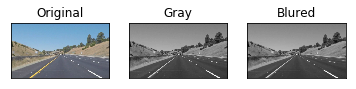

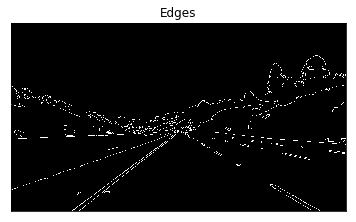

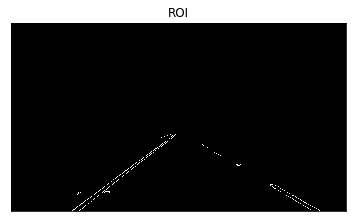

Original number of lane 888
Left lane line 5
Right lane line 7


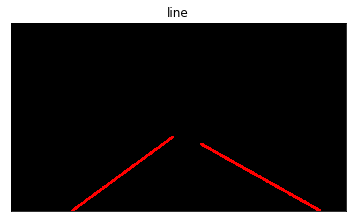

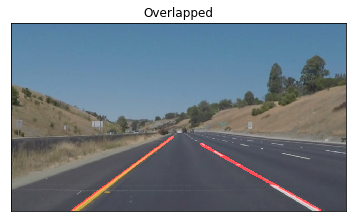

In [6]:
# Read image
#ori_img = mpimg.imread('test_images/solidWhiteRight.jpg')
ori_img = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
h = ori_img.shape[0]
w = ori_img.shape[1]
print('height: {}, width: {}'.format(h, w))

plt.subplot(131),plt.imshow(ori_img)
plt.title('Original'), plt.xticks([]), plt.yticks([])

# 1:[Pre-processing]: convert image into gray scale and blur it with Gaussian filter.
gray_img = grayscale(ori_img)
plt.subplot(132),plt.imshow(gray_img, cmap='gray')
plt.title('Gray'), plt.xticks([]), plt.yticks([])

blurred_gray_img = gaussian_blur(gray_img, 5)
plt.subplot(133),plt.imshow(blurred_gray_img, cmap='gray')
plt.title('Blured'), plt.xticks([]), plt.yticks([])
plt.show()

# 2. Use Canny edge detection to extract the contour.
edges = canny(blurred_gray_img, 50, 130)
plt.imshow(edges, cmap='gray')
plt.title('Edges'), plt.xticks([]), plt.yticks([])
plt.show()

# 3. Implement Region of Interests (ROI) and Hough transform to extract potential line.
ROI = np.array([[(50, h), (450, 320), (490, 320), (w-50, h)]], dtype=np.int32)
masked_img = region_of_interest(edges, ROI)
plt.imshow(masked_img, cmap='gray')
plt.title('ROI'), plt.xticks([]), plt.yticks([])
plt.show()

# Define the Hough transform parameters
rho = 1                         # distance resolution in pixels of the Hough grid
theta = np.pi/180               # angular resolution in radians of the Hough grid
threshold = 2                   # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5             # minimum number of pixels making up a line
max_line_gap = 50               # maximum gap in pixels between connectable line segments

# 4. [Post-processing]: colorize the detected lane and extropolate the dash-line into solid line.
line_img = hough_lines(masked_img, rho, theta, threshold, min_line_length, max_line_gap)
plt.imshow(line_img, cmap='gray')
plt.title('line'), plt.xticks([]), plt.yticks([])
plt.show()

# 5. [Post-processing]: use cv2.addWeighted function to overlap the mask and original image.
overlapped_img = weighted_img(line_img, ori_img)
plt.imshow(overlapped_img)
plt.title('Overlapped'), plt.xticks([]), plt.yticks([])
plt.show()


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [7]:
# Run this if you have the error
#import imcageio
#imageio.plugins.ffmpeg.download()

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    

    # 1:[Pre-processing]: convert image into gray scale and blur it with Gaussian filter.
    gray_img = grayscale(image)
    blurred_gray_img = gaussian_blur(gray_img, 5)

    # 2. Use Canny edge detection to extract the contour.
    edges = canny(blurred_gray_img, 50, 150)

    # 3. Implement Region of Interests (ROI) and Hough transform to extract potential line.
    ROI = np.array([[(50, h), (450, 320), (490, 320), (w-50, h)]], dtype=np.int32)
    masked_img = region_of_interest(edges, ROI)

    # Define the Hough transform parameters
    rho = 1                         # distance resolution in pixels of the Hough grid
    theta = np.pi/180               # angular resolution in radians of the Hough grid
    threshold = 2                   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 3             # minimum number of pixels making up a line
    max_line_gap = 80               # maximum gap in pixels between connectable line segments

    # 4. [Post-processing]: colorize the detected lane and extropolate the dash-line into solid line.
    line_img = hough_lines(masked_img, rho, theta, threshold, min_line_length, max_line_gap)


    # 5. [Post-processing]: use cv2.addWeighted function to overlap the mask and original image.
    overlapped_img = weighted_img(line_img, ori_img)

    return overlapped_img

Original number of lane 992
Left lane line 6
Right lane line 8


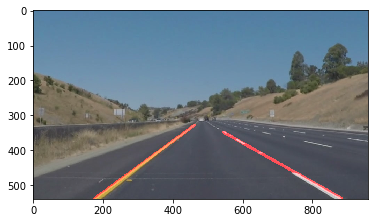

In [21]:
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
#image = (mpimg.imread('test_images/whiteCarLaneSwitch.jpg') * 255).astype('uint8')
#image = 'test_images/whiteCarLaneSwitch.jpg'
processImg = process_image(image)
plt.imshow(processImg)
plt.show()

Let's try the one with the solid white lane on the right first ...

In [19]:
white_output = 'solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos\solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Original number of lane 944
Left lane line 8
Right lane line 14
[MoviePy] >>>> Building video solidWhiteRight.mp4
[MoviePy] Writing video solidWhiteRight.mp4




  0%|                                                                                                                                  | 0/222 [00:00<?, ?it/s]

Original number of lane 944
Left lane line 8
Right lane line 14




  0%|▌                                                                                                                         | 1/222 [00:00<00:43,  5.13it/s]

Original number of lane 984
Left lane line 14
Right lane line 22
Original number of lane 1004
Left lane line 9
Right lane line 19
Original number of lane 884
Left lane line 7
Right lane line 8




  2%|██▏                                                                                                                       | 4/222 [00:00<00:32,  6.81it/s]

Original number of lane 808
Left lane line 20
Right lane line 15
Original number of lane 748
Left lane line 5
Right lane line 3
Original number of lane 804
Left lane line 12
Right lane line 13




  3%|███▊                                                                                                                      | 7/222 [00:00<00:24,  8.82it/s]

Original number of lane 808
Left lane line 7
Right lane line 8
Original number of lane 836
Left lane line 6
Right lane line 14
Original number of lane 864
Left lane line 11
Right lane line 9




  5%|█████▍                                                                                                                   | 10/222 [00:00<00:19, 11.16it/s]

Original number of lane 568
Left lane line 8
Right lane line 12
Original number of lane 884
Left lane line 10
Right lane line 17
Original number of lane 880
Left lane line 6
Right lane line 14




  6%|███████                                                                                                                  | 13/222 [00:00<00:15, 13.49it/s]

Original number of lane 1032
Left lane line 11
Right lane line 19
Original number of lane 896
Left lane line 18
Right lane line 10
Original number of lane 904
Left lane line 24
Right lane line 16




  7%|████████▋                                                                                                                | 16/222 [00:00<00:13, 15.80it/s]

Original number of lane 580
Left lane line 4
Right lane line 10
Original number of lane 456
Left lane line 10
Right lane line 10
Original number of lane 456
Left lane line 5
Right lane line 8
Original number of lane 796
Left lane line 10
Right lane line 10




  9%|██████████▉                                                                                                              | 20/222 [00:00<00:10, 18.37it/s]

Original number of lane 756
Left lane line 13
Right lane line 17
Original number of lane 764
Left lane line 16
Right lane line 12
Original number of lane 1000
Left lane line 8
Right lane line 14
Original number of lane 1024
Left lane line 14
Right lane line 10




 11%|█████████████                                                                                                            | 24/222 [00:00<00:09, 21.16it/s]

Original number of lane 1044
Left lane line 2
Right lane line 11
Original number of lane 752
Left lane line 11
Right lane line 13
Original number of lane 788
Left lane line 7
Right lane line 10
Original number of lane 884
Left lane line 8
Right lane line 10




 13%|███████████████▎                                                                                                         | 28/222 [00:01<00:08, 24.11it/s]

Original number of lane 844
Left lane line 9
Right lane line 6
Original number of lane 816
Left lane line 12
Right lane line 14
Original number of lane 704
Left lane line 6
Right lane line 16
Original number of lane 796
Left lane line 5
Right lane line 10




 14%|█████████████████▍                                                                                                       | 32/222 [00:01<00:07, 26.93it/s]

Original number of lane 764
Left lane line 5
Right lane line 22
Original number of lane 820
Left lane line 9
Right lane line 6
Original number of lane 588
Left lane line 9
Right lane line 12
Original number of lane 936
Left lane line 13
Right lane line 11




 16%|███████████████████▌                                                                                                     | 36/222 [00:01<00:06, 29.14it/s]

Original number of lane 820
Left lane line 15
Right lane line 16
Original number of lane 784
Left lane line 8
Right lane line 11
Original number of lane 1072
Left lane line 10
Right lane line 17
Original number of lane 928
Left lane line 6
Right lane line 10




 18%|█████████████████████▊                                                                                                   | 40/222 [00:01<00:05, 31.50it/s]

Original number of lane 820
Left lane line 6
Right lane line 9
Original number of lane 772
Left lane line 5
Right lane line 14
Original number of lane 824
Left lane line 11
Right lane line 15
Original number of lane 864
Left lane line 8
Right lane line 10




 20%|███████████████████████▉                                                                                                 | 44/222 [00:01<00:05, 33.39it/s]

Original number of lane 852
Left lane line 12
Right lane line 11
Original number of lane 636
Left lane line 5
Right lane line 15
Original number of lane 820
Left lane line 6
Right lane line 8
Original number of lane 836
Left lane line 15
Right lane line 10




 22%|██████████████████████████▏                                                                                              | 48/222 [00:01<00:05, 34.77it/s]

Original number of lane 580
Left lane line 4
Right lane line 14
Original number of lane 948
Left lane line 17
Right lane line 18
Original number of lane 1072
Left lane line 9
Right lane line 14
Original number of lane 1036
Left lane line 7
Right lane line 12




 23%|████████████████████████████▎                                                                                            | 52/222 [00:01<00:04, 34.95it/s]

Original number of lane 700
Left lane line 16
Right lane line 5
Original number of lane 752
Left lane line 7
Right lane line 13
Original number of lane 908
Left lane line 13
Right lane line 15
Original number of lane 748
Left lane line 10
Right lane line 10




 25%|██████████████████████████████▌                                                                                          | 56/222 [00:01<00:04, 35.18it/s]

Original number of lane 996
Left lane line 5
Right lane line 15
Original number of lane 1012
Left lane line 12
Right lane line 18
Original number of lane 872
Left lane line 15
Right lane line 5
Original number of lane 940
Left lane line 9
Right lane line 18




 27%|████████████████████████████████▋                                                                                        | 60/222 [00:01<00:04, 34.07it/s]

Original number of lane 1060
Left lane line 6
Right lane line 12
Original number of lane 1100
Left lane line 14
Right lane line 19
Original number of lane 1088
Left lane line 4
Right lane line 11
Original number of lane 968
Left lane line 16
Right lane line 13




 29%|██████████████████████████████████▉                                                                                      | 64/222 [00:02<00:04, 34.02it/s]

Original number of lane 368
Left lane line 19
Right lane line 13
Original number of lane 436
Left lane line 17
Right lane line 9
Original number of lane 364
Left lane line 9
Right lane line 9
Original number of lane 924
Left lane line 8
Right lane line 13




 31%|█████████████████████████████████████                                                                                    | 68/222 [00:02<00:04, 34.78it/s]

Original number of lane 464
Left lane line 7
Right lane line 14
Original number of lane 928
Left lane line 3
Right lane line 10
Original number of lane 648
Left lane line 15
Right lane line 12
Original number of lane 900
Left lane line 4
Right lane line 12




 32%|███████████████████████████████████████▏                                                                                 | 72/222 [00:02<00:04, 35.62it/s]

Original number of lane 620
Left lane line 14
Right lane line 25
Original number of lane 396
Left lane line 18
Right lane line 14
Original number of lane 1212
Left lane line 7
Right lane line 14
Original number of lane 1020
Left lane line 15
Right lane line 17




 34%|█████████████████████████████████████████▍                                                                               | 76/222 [00:02<00:04, 35.94it/s]

Original number of lane 820
Left lane line 7
Right lane line 12
Original number of lane 252
Left lane line 11
Right lane line 9
Original number of lane 792
Left lane line 10
Right lane line 14
Original number of lane 524
Left lane line 10
Right lane line 10




 36%|███████████████████████████████████████████▌                                                                             | 80/222 [00:02<00:03, 36.36it/s]

Original number of lane 924
Left lane line 1
Right lane line 8
Original number of lane 984
Left lane line 7
Right lane line 13
Original number of lane 980
Left lane line 8
Right lane line 13
Original number of lane 788
Left lane line 14
Right lane line 18




 38%|█████████████████████████████████████████████▊                                                                           | 84/222 [00:02<00:03, 36.06it/s]

Original number of lane 1036
Left lane line 12
Right lane line 17
Original number of lane 1012
Left lane line 21
Right lane line 24
Original number of lane 1112
Left lane line 11
Right lane line 10
Original number of lane 1036
Left lane line 15
Right lane line 14




 40%|███████████████████████████████████████████████▉                                                                         | 88/222 [00:02<00:03, 36.35it/s]

Original number of lane 656
Left lane line 16
Right lane line 9
Original number of lane 844
Left lane line 12
Right lane line 16
Original number of lane 816
Left lane line 4
Right lane line 16
Original number of lane 784
Left lane line 2
Right lane line 14




 41%|██████████████████████████████████████████████████▏                                                                      | 92/222 [00:02<00:03, 37.06it/s]

Original number of lane 852
Left lane line 10
Right lane line 16
Original number of lane 860
Left lane line 5
Right lane line 7
Original number of lane 844
Left lane line 4
Right lane line 9
Original number of lane 984
Left lane line 13
Right lane line 16




 43%|████████████████████████████████████████████████████▎                                                                    | 96/222 [00:02<00:03, 36.65it/s]

Original number of lane 908
Left lane line 12
Right lane line 13
Original number of lane 896
Left lane line 19
Right lane line 16
Original number of lane 888
Left lane line 14
Right lane line 21
Original number of lane 924
Left lane line 5
Right lane line 15




 45%|██████████████████████████████████████████████████████                                                                  | 100/222 [00:03<00:03, 36.07it/s]

Original number of lane 640
Left lane line 15
Right lane line 19
Original number of lane 732
Left lane line 7
Right lane line 14
Original number of lane 868
Left lane line 6
Right lane line 14
Original number of lane 872
Left lane line 9
Right lane line 18




 47%|████████████████████████████████████████████████████████▏                                                               | 104/222 [00:03<00:03, 35.58it/s]

Original number of lane 592
Left lane line 9
Right lane line 13
Original number of lane 648
Left lane line 6
Right lane line 16
Original number of lane 780
Left lane line 16
Right lane line 15
Original number of lane 904
Left lane line 5
Right lane line 13




 49%|██████████████████████████████████████████████████████████▍                                                             | 108/222 [00:03<00:03, 36.30it/s]

Original number of lane 948
Left lane line 8
Right lane line 18
Original number of lane 812
Left lane line 26
Right lane line 18
Original number of lane 988
Left lane line 10
Right lane line 17
Original number of lane 848
Left lane line 12
Right lane line 10




 50%|████████████████████████████████████████████████████████████▌                                                           | 112/222 [00:03<00:03, 36.42it/s]

Original number of lane 908
Left lane line 6
Right lane line 13
Original number of lane 772
Left lane line 5
Right lane line 11
Original number of lane 700
Left lane line 11
Right lane line 14
Original number of lane 736
Left lane line 8
Right lane line 8




 52%|██████████████████████████████████████████████████████████████▋                                                         | 116/222 [00:03<00:02, 36.01it/s]

Original number of lane 852
Left lane line 9
Right lane line 22
Original number of lane 816
Left lane line 5
Right lane line 4
Original number of lane 732
Left lane line 2
Right lane line 15
Original number of lane 908
Left lane line 12
Right lane line 22




 54%|████████████████████████████████████████████████████████████████▊                                                       | 120/222 [00:03<00:02, 35.73it/s]

Original number of lane 936
Left lane line 19
Right lane line 14
Original number of lane 1168
Left lane line 10
Right lane line 16
Original number of lane 968
Left lane line 6
Right lane line 11
Original number of lane 1024
Left lane line 13
Right lane line 16




 56%|███████████████████████████████████████████████████████████████████                                                     | 124/222 [00:03<00:02, 35.53it/s]

Original number of lane 844
Left lane line 7
Right lane line 13
Original number of lane 548
Left lane line 4
Right lane line 17
Original number of lane 844
Left lane line 8
Right lane line 7
Original number of lane 772
Left lane line 11
Right lane line 10




 58%|█████████████████████████████████████████████████████████████████████▏                                                  | 128/222 [00:03<00:02, 36.26it/s]

Original number of lane 848
Left lane line 11
Right lane line 14
Original number of lane 868
Left lane line 6
Right lane line 8
Original number of lane 928
Left lane line 11
Right lane line 13
Original number of lane 852
Left lane line 11
Right lane line 15




 59%|███████████████████████████████████████████████████████████████████████▎                                                | 132/222 [00:03<00:02, 36.29it/s]

Original number of lane 1028
Left lane line 16
Right lane line 10
Original number of lane 1068
Left lane line 7
Right lane line 14
Original number of lane 884
Left lane line 13
Right lane line 13
Original number of lane 820
Left lane line 6
Right lane line 13




 61%|█████████████████████████████████████████████████████████████████████████▌                                              | 136/222 [00:04<00:02, 36.12it/s]

Original number of lane 772
Left lane line 9
Right lane line 16
Original number of lane 560
Left lane line 9
Right lane line 12
Original number of lane 288
Left lane line 8
Right lane line 8
Original number of lane 752
Left lane line 9
Right lane line 14




 63%|███████████████████████████████████████████████████████████████████████████▋                                            | 140/222 [00:04<00:02, 36.79it/s]

Original number of lane 888
Left lane line 14
Right lane line 12
Original number of lane 720
Left lane line 13
Right lane line 12
Original number of lane 952
Left lane line 5
Right lane line 13
Original number of lane 860
Left lane line 14
Right lane line 15




 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 144/222 [00:04<00:02, 36.26it/s]

Original number of lane 944
Left lane line 7
Right lane line 16
Original number of lane 956
Left lane line 15
Right lane line 14
Original number of lane 1000
Left lane line 12
Right lane line 16
Original number of lane 952
Left lane line 14
Right lane line 11




 67%|████████████████████████████████████████████████████████████████████████████████                                        | 148/222 [00:04<00:02, 36.19it/s]

Original number of lane 684
Left lane line 10
Right lane line 13
Original number of lane 396
Left lane line 9
Right lane line 4
Original number of lane 528
Left lane line 18
Right lane line 9
Original number of lane 720
Left lane line 1
Right lane line 11




 68%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 152/222 [00:04<00:01, 37.05it/s]

Original number of lane 848
Left lane line 5
Right lane line 17
Original number of lane 824
Left lane line 9
Right lane line 15
Original number of lane 716
Left lane line 9
Right lane line 17
Original number of lane 800
Left lane line 7
Right lane line 7




 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 156/222 [00:04<00:01, 36.24it/s]

Original number of lane 748
Left lane line 14
Right lane line 12
Original number of lane 768
Left lane line 13
Right lane line 21
Original number of lane 880
Left lane line 15
Right lane line 13
Original number of lane 768
Left lane line 12
Right lane line 14




 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 160/222 [00:04<00:01, 35.41it/s]

Original number of lane 544
Left lane line 10
Right lane line 14
Original number of lane 524
Left lane line 2
Right lane line 15
Original number of lane 656
Left lane line 11
Right lane line 10
Original number of lane 600
Left lane line 5
Right lane line 8




 74%|████████████████████████████████████████████████████████████████████████████████████████▋                               | 164/222 [00:04<00:01, 36.18it/s]

Original number of lane 688
Left lane line 9
Right lane line 11
Original number of lane 752
Left lane line 14
Right lane line 8
Original number of lane 764
Left lane line 7
Right lane line 6
Original number of lane 396
Left lane line 2
Right lane line 13




 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 168/222 [00:04<00:01, 36.33it/s]

Original number of lane 844
Left lane line 12
Right lane line 6
Original number of lane 1016
Left lane line 11
Right lane line 6
Original number of lane 1004
Left lane line 8
Right lane line 17
Original number of lane 852
Left lane line 13
Right lane line 16




 77%|████████████████████████████████████████████████████████████████████████████████████████████▉                           | 172/222 [00:05<00:01, 35.56it/s]

Original number of lane 788
Left lane line 7
Right lane line 17
Original number of lane 688
Left lane line 3
Right lane line 15
Original number of lane 692
Left lane line 6
Right lane line 11
Original number of lane 640
Left lane line 1
Right lane line 20




 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 176/222 [00:05<00:01, 35.90it/s]

Original number of lane 336
Left lane line 1
Right lane line 6
Original number of lane 828
Left lane line 6
Right lane line 15
Original number of lane 808
Left lane line 13
Right lane line 13
Original number of lane 484
Left lane line 0
Right lane line 11


IndexError: list index out of range



 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 176/222 [00:21<00:05,  8.15it/s]

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [22]:
yellow_output = 'solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Original number of lane 624
Left lane line 22
Right lane line 10
[MoviePy] >>>> Building video solidYellowLeft.mp4
[MoviePy] Writing video solidYellowLeft.mp4





  0%|                                                                                                                                  | 0/682 [00:00<?, ?it/s]

Original number of lane 624
Left lane line 22
Right lane line 10
Original number of lane 1212
Left lane line 17
Right lane line 9
Original number of lane 1180
Left lane line 12
Right lane line 13





  0%|▌                                                                                                                         | 3/682 [00:00<00:26, 25.64it/s]

Original number of lane 768
Left lane line 13
Right lane line 12
Original number of lane 940
Left lane line 17
Right lane line 10
Original number of lane 296
Left lane line 11
Right lane line 12
Original number of lane 800
Left lane line 9
Right lane line 4





  1%|█▎                                                                                                                        | 7/682 [00:00<00:23, 28.74it/s]

Original number of lane 452
Left lane line 11
Right lane line 12
Original number of lane 788
Left lane line 10
Right lane line 11
Original number of lane 872
Left lane line 9
Right lane line 13
Original number of lane 852
Left lane line 11
Right lane line 9





  2%|█▉                                                                                                                       | 11/682 [00:00<00:21, 31.24it/s]

Original number of lane 860
Left lane line 14
Right lane line 11
Original number of lane 940
Left lane line 5
Right lane line 10
Original number of lane 944
Left lane line 19
Right lane line 17
Original number of lane 952
Left lane line 12
Right lane line 16
Original number of lane 860
Left lane line 18
Right lane line 21





  2%|██▊                                                                                                                      | 16/682 [00:00<00:19, 33.30it/s]

Original number of lane 680
Left lane line 22
Right lane line 13
Original number of lane 804
Left lane line 15
Right lane line 12
Original number of lane 872
Left lane line 11
Right lane line 6
Original number of lane 840
Left lane line 10
Right lane line 9
Original number of lane 688
Left lane line 6
Right lane line 15





  3%|███▋                                                                                                                     | 21/682 [00:00<00:18, 36.13it/s]

Original number of lane 904
Left lane line 3
Right lane line 7
Original number of lane 496
Left lane line 12
Right lane line 24
Original number of lane 760
Left lane line 16
Right lane line 6
Original number of lane 944
Left lane line 6
Right lane line 9





  4%|████▍                                                                                                                    | 25/682 [00:00<00:18, 36.40it/s]

Original number of lane 888
Left lane line 13
Right lane line 23
Original number of lane 1012
Left lane line 12
Right lane line 11
Original number of lane 1024
Left lane line 8
Right lane line 5
Original number of lane 948
Left lane line 17
Right lane line 9





  4%|█████▏                                                                                                                   | 29/682 [00:00<00:18, 36.19it/s]

Original number of lane 864
Left lane line 8
Right lane line 5
Original number of lane 792
Left lane line 13
Right lane line 6
Original number of lane 656
Left lane line 10
Right lane line 7
Original number of lane 688
Left lane line 4
Right lane line 8





  5%|█████▊                                                                                                                   | 33/682 [00:00<00:18, 35.85it/s]

Original number of lane 712
Left lane line 7
Right lane line 10
Original number of lane 760
Left lane line 12
Right lane line 11
Original number of lane 696
Left lane line 7
Right lane line 8
Original number of lane 900
Left lane line 13
Right lane line 5





  5%|██████▌                                                                                                                  | 37/682 [00:01<00:18, 35.62it/s]

Original number of lane 952
Left lane line 8
Right lane line 10
Original number of lane 720
Left lane line 15
Right lane line 21
Original number of lane 892
Left lane line 16
Right lane line 13
Original number of lane 908
Left lane line 15
Right lane line 9





  6%|███████▎                                                                                                                 | 41/682 [00:01<00:18, 34.45it/s]

Original number of lane 880
Left lane line 12
Right lane line 11
Original number of lane 580
Left lane line 18
Right lane line 10
Original number of lane 692
Left lane line 9
Right lane line 11
Original number of lane 584
Left lane line 10
Right lane line 14





  7%|███████▉                                                                                                                 | 45/682 [00:01<00:18, 35.28it/s]

Original number of lane 792
Left lane line 8
Right lane line 11
Original number of lane 732
Left lane line 10
Right lane line 9
Original number of lane 572
Left lane line 9
Right lane line 16
Original number of lane 964
Left lane line 8
Right lane line 11





  7%|████████▋                                                                                                                | 49/682 [00:01<00:18, 34.95it/s]

Original number of lane 900
Left lane line 11
Right lane line 4
Original number of lane 1024
Left lane line 14
Right lane line 16
Original number of lane 816
Left lane line 13
Right lane line 17
Original number of lane 1072
Left lane line 13
Right lane line 5





  8%|█████████▍                                                                                                               | 53/682 [00:01<00:18, 34.09it/s]

Original number of lane 944
Left lane line 8
Right lane line 13
Original number of lane 668
Left lane line 12
Right lane line 15
Original number of lane 784
Left lane line 4
Right lane line 5
Original number of lane 596
Left lane line 12
Right lane line 12





  8%|██████████                                                                                                               | 57/682 [00:01<00:18, 33.86it/s]

Original number of lane 904
Left lane line 13
Right lane line 11
Original number of lane 812
Left lane line 12
Right lane line 12
Original number of lane 836
Left lane line 9
Right lane line 16
Original number of lane 740
Left lane line 14
Right lane line 17





  9%|██████████▊                                                                                                              | 61/682 [00:01<00:18, 33.28it/s]

Original number of lane 892
Left lane line 20
Right lane line 7
Original number of lane 980
Left lane line 6
Right lane line 8
Original number of lane 968
Left lane line 7
Right lane line 18
Original number of lane 1000
Left lane line 19
Right lane line 16





 10%|███████████▌                                                                                                             | 65/682 [00:01<00:18, 33.38it/s]

Original number of lane 980
Left lane line 15
Right lane line 13
Original number of lane 540
Left lane line 6
Right lane line 29
Original number of lane 888
Left lane line 19
Right lane line 12
Original number of lane 772
Left lane line 10
Right lane line 15





 10%|████████████▏                                                                                                            | 69/682 [00:01<00:18, 33.37it/s]

Original number of lane 468
Left lane line 17
Right lane line 12
Original number of lane 788
Left lane line 12
Right lane line 12
Original number of lane 780
Left lane line 12
Right lane line 12
Original number of lane 772
Left lane line 16
Right lane line 11





 11%|████████████▉                                                                                                            | 73/682 [00:02<00:17, 34.66it/s]

Original number of lane 512
Left lane line 7
Right lane line 17
Original number of lane 876
Left lane line 10
Right lane line 9
Original number of lane 972
Left lane line 10
Right lane line 9
Original number of lane 1044
Left lane line 13
Right lane line 13





 11%|█████████████▋                                                                                                           | 77/682 [00:02<00:17, 35.06it/s]

Original number of lane 948
Left lane line 22
Right lane line 9
Original number of lane 788
Left lane line 9
Right lane line 12
Original number of lane 984
Left lane line 16
Right lane line 3
Original number of lane 840
Left lane line 16
Right lane line 13





 12%|██████████████▎                                                                                                          | 81/682 [00:02<00:17, 35.35it/s]

Original number of lane 856
Left lane line 16
Right lane line 15
Original number of lane 820
Left lane line 18
Right lane line 11
Original number of lane 448
Left lane line 15
Right lane line 13
Original number of lane 844
Left lane line 26
Right lane line 11





 12%|███████████████                                                                                                          | 85/682 [00:02<00:16, 35.55it/s]

Original number of lane 552
Left lane line 14
Right lane line 14
Original number of lane 680
Left lane line 15
Right lane line 13
Original number of lane 800
Left lane line 12
Right lane line 10
Original number of lane 1024
Left lane line 14
Right lane line 6





 13%|███████████████▊                                                                                                         | 89/682 [00:02<00:17, 33.71it/s]

Original number of lane 896
Left lane line 11
Right lane line 23
Original number of lane 968
Left lane line 17
Right lane line 13
Original number of lane 1000
Left lane line 11
Right lane line 15
Original number of lane 756
Left lane line 13
Right lane line 18





 14%|████████████████▌                                                                                                        | 93/682 [00:02<00:17, 34.11it/s]

Original number of lane 868
Left lane line 12
Right lane line 6
Original number of lane 764
Left lane line 5
Right lane line 11
Original number of lane 780
Left lane line 17
Right lane line 16
Original number of lane 888
Left lane line 14
Right lane line 7





 14%|█████████████████▏                                                                                                       | 97/682 [00:02<00:17, 33.79it/s]

Original number of lane 692
Left lane line 9
Right lane line 16
Original number of lane 880
Left lane line 10
Right lane line 9
Original number of lane 748
Left lane line 20
Right lane line 14
Original number of lane 984
Left lane line 30
Right lane line 8





 15%|█████████████████▊                                                                                                      | 101/682 [00:02<00:17, 34.08it/s]

Original number of lane 960
Left lane line 12
Right lane line 19
Original number of lane 892
Left lane line 17
Right lane line 9
Original number of lane 1012
Left lane line 21
Right lane line 10
Original number of lane 1040
Left lane line 10
Right lane line 11





 15%|██████████████████▍                                                                                                     | 105/682 [00:03<00:17, 33.60it/s]

Original number of lane 1112
Left lane line 17
Right lane line 9
Original number of lane 900
Left lane line 10
Right lane line 7
Original number of lane 864
Left lane line 12
Right lane line 12
Original number of lane 804
Left lane line 12
Right lane line 6





 16%|███████████████████▏                                                                                                    | 109/682 [00:03<00:17, 33.52it/s]

Original number of lane 772
Left lane line 11
Right lane line 8
Original number of lane 896
Left lane line 8
Right lane line 16
Original number of lane 956
Left lane line 10
Right lane line 5
Original number of lane 776
Left lane line 16
Right lane line 14





 17%|███████████████████▉                                                                                                    | 113/682 [00:03<00:16, 33.55it/s]

Original number of lane 920
Left lane line 11
Right lane line 11
Original number of lane 676
Left lane line 12
Right lane line 12
Original number of lane 980
Left lane line 13
Right lane line 11
Original number of lane 712
Left lane line 16
Right lane line 20





 17%|████████████████████▌                                                                                                   | 117/682 [00:03<00:16, 33.65it/s]

Original number of lane 1076
Left lane line 13
Right lane line 14
Original number of lane 688
Left lane line 18
Right lane line 17
Original number of lane 632
Left lane line 17
Right lane line 10
Original number of lane 780
Left lane line 12
Right lane line 13





 18%|█████████████████████▎                                                                                                  | 121/682 [00:03<00:16, 33.47it/s]

Original number of lane 668
Left lane line 11
Right lane line 8
Original number of lane 380
Left lane line 6
Right lane line 18
Original number of lane 408
Left lane line 11
Right lane line 16
Original number of lane 924
Left lane line 21
Right lane line 10





 18%|█████████████████████▉                                                                                                  | 125/682 [00:03<00:16, 33.60it/s]

Original number of lane 632
Left lane line 18
Right lane line 27
Original number of lane 744
Left lane line 12
Right lane line 12
Original number of lane 1140
Left lane line 9
Right lane line 5
Original number of lane 1032
Left lane line 7
Right lane line 19





 19%|██████████████████████▋                                                                                                 | 129/682 [00:03<00:16, 33.10it/s]

Original number of lane 860
Left lane line 13
Right lane line 10
Original number of lane 904
Left lane line 22
Right lane line 5
Original number of lane 748
Left lane line 21
Right lane line 9
Original number of lane 716
Left lane line 17
Right lane line 18





 20%|███████████████████████▍                                                                                                | 133/682 [00:03<00:16, 33.34it/s]

Original number of lane 728
Left lane line 10
Right lane line 13
Original number of lane 864
Left lane line 10
Right lane line 11
Original number of lane 748
Left lane line 16
Right lane line 14
Original number of lane 820
Left lane line 15
Right lane line 12





 20%|████████████████████████                                                                                                | 137/682 [00:03<00:16, 33.34it/s]

Original number of lane 888
Left lane line 11
Right lane line 6
Original number of lane 960
Left lane line 14
Right lane line 12
Original number of lane 1008
Left lane line 13
Right lane line 13
Original number of lane 1128
Left lane line 12
Right lane line 15





 21%|████████████████████████▊                                                                                               | 141/682 [00:04<00:16, 33.09it/s]

Original number of lane 1044
Left lane line 9
Right lane line 17
Original number of lane 1048
Left lane line 10
Right lane line 8
Original number of lane 900
Left lane line 14
Right lane line 4
Original number of lane 612
Left lane line 22
Right lane line 19





 21%|█████████████████████████▌                                                                                              | 145/682 [00:04<00:15, 33.66it/s]

Original number of lane 632
Left lane line 16
Right lane line 13
Original number of lane 608
Left lane line 13
Right lane line 18
Original number of lane 900
Left lane line 9
Right lane line 5
Original number of lane 856
Left lane line 9
Right lane line 6





 22%|██████████████████████████▏                                                                                             | 149/682 [00:04<00:15, 33.65it/s]

Original number of lane 908
Left lane line 6
Right lane line 10
Original number of lane 868
Left lane line 13
Right lane line 14
Original number of lane 924
Left lane line 12
Right lane line 8
Original number of lane 1104
Left lane line 21
Right lane line 10





 22%|██████████████████████████▉                                                                                             | 153/682 [00:04<00:15, 33.98it/s]

Original number of lane 948
Left lane line 14
Right lane line 14
Original number of lane 892
Left lane line 10
Right lane line 9
Original number of lane 980
Left lane line 16
Right lane line 7
Original number of lane 828
Left lane line 8
Right lane line 9





 23%|███████████████████████████▌                                                                                            | 157/682 [00:04<00:15, 33.53it/s]

Original number of lane 784
Left lane line 9
Right lane line 8
Original number of lane 884
Left lane line 12
Right lane line 11
Original number of lane 928
Left lane line 3
Right lane line 9
Original number of lane 844
Left lane line 14
Right lane line 11





 24%|████████████████████████████▎                                                                                           | 161/682 [00:04<00:15, 34.24it/s]

Original number of lane 784
Left lane line 21
Right lane line 15
Original number of lane 864
Left lane line 20
Right lane line 20
Original number of lane 396
Left lane line 16
Right lane line 15
Original number of lane 1104
Left lane line 18
Right lane line 17





 24%|█████████████████████████████                                                                                           | 165/682 [00:04<00:14, 34.76it/s]

Original number of lane 1032
Left lane line 14
Right lane line 14
Original number of lane 928
Left lane line 17
Right lane line 7
Original number of lane 760
Left lane line 16
Right lane line 16
Original number of lane 840
Left lane line 14
Right lane line 8





 25%|█████████████████████████████▋                                                                                          | 169/682 [00:04<00:14, 35.51it/s]

Original number of lane 876
Left lane line 17
Right lane line 7
Original number of lane 788
Left lane line 9
Right lane line 10
Original number of lane 920
Left lane line 14
Right lane line 7
Original number of lane 948
Left lane line 10
Right lane line 9





 25%|██████████████████████████████▍                                                                                         | 173/682 [00:05<00:14, 35.57it/s]

Original number of lane 688
Left lane line 7
Right lane line 8
Original number of lane 856
Left lane line 15
Right lane line 11
Original number of lane 828
Left lane line 21
Right lane line 18
Original number of lane 744
Left lane line 6
Right lane line 17





 26%|███████████████████████████████▏                                                                                        | 177/682 [00:05<00:14, 34.24it/s]

Original number of lane 1004
Left lane line 11
Right lane line 15
Original number of lane 936
Left lane line 14
Right lane line 10
Original number of lane 1024
Left lane line 10
Right lane line 6
Original number of lane 852
Left lane line 14
Right lane line 13





 27%|███████████████████████████████▊                                                                                        | 181/682 [00:05<00:14, 34.49it/s]

Original number of lane 604
Left lane line 12
Right lane line 13
Original number of lane 616
Left lane line 13
Right lane line 9
Original number of lane 792
Left lane line 12
Right lane line 7
Original number of lane 900
Left lane line 10
Right lane line 7





 27%|████████████████████████████████▌                                                                                       | 185/682 [00:05<00:14, 34.94it/s]

Original number of lane 844
Left lane line 11
Right lane line 7
Original number of lane 816
Left lane line 9
Right lane line 13
Original number of lane 892
Left lane line 9
Right lane line 9
Original number of lane 768
Left lane line 17
Right lane line 12





 28%|█████████████████████████████████▎                                                                                      | 189/682 [00:05<00:14, 34.89it/s]

Original number of lane 952
Left lane line 15
Right lane line 15
Original number of lane 1124
Left lane line 14
Right lane line 8
Original number of lane 984
Left lane line 8
Right lane line 15
Original number of lane 1032
Left lane line 10
Right lane line 7





 28%|█████████████████████████████████▉                                                                                      | 193/682 [00:05<00:14, 34.68it/s]

Original number of lane 816
Left lane line 14
Right lane line 11
Original number of lane 720
Left lane line 11
Right lane line 12
Original number of lane 524
Left lane line 9
Right lane line 15
Original number of lane 732
Left lane line 12
Right lane line 10





 29%|██████████████████████████████████▋                                                                                     | 197/682 [00:05<00:13, 34.80it/s]

Original number of lane 916
Left lane line 14
Right lane line 5
Original number of lane 940
Left lane line 13
Right lane line 6
Original number of lane 460
Left lane line 16
Right lane line 16
Original number of lane 880
Left lane line 18
Right lane line 14





 29%|███████████████████████████████████▎                                                                                    | 201/682 [00:05<00:13, 35.07it/s]

Original number of lane 1120
Left lane line 16
Right lane line 11
Original number of lane 1088
Left lane line 21
Right lane line 12
Original number of lane 1136
Left lane line 17
Right lane line 10
Original number of lane 868
Left lane line 16
Right lane line 11





 30%|████████████████████████████████████                                                                                    | 205/682 [00:05<00:13, 34.80it/s]

Original number of lane 1020
Left lane line 18
Right lane line 12
Original number of lane 824
Left lane line 9
Right lane line 6
Original number of lane 852
Left lane line 17
Right lane line 7
Original number of lane 860
Left lane line 8
Right lane line 7





 31%|████████████████████████████████████▊                                                                                   | 209/682 [00:06<00:13, 35.35it/s]

Original number of lane 828
Left lane line 17
Right lane line 11
Original number of lane 972
Left lane line 9
Right lane line 7
Original number of lane 856
Left lane line 19
Right lane line 11
Original number of lane 1072
Left lane line 6
Right lane line 7





 31%|█████████████████████████████████████▍                                                                                  | 213/682 [00:06<00:13, 35.55it/s]

Original number of lane 936
Left lane line 14
Right lane line 10
Original number of lane 1148
Left lane line 12
Right lane line 10
Original number of lane 1044
Left lane line 27
Right lane line 13
Original number of lane 1180
Left lane line 19
Right lane line 2





 32%|██████████████████████████████████████▏                                                                                 | 217/682 [00:06<00:13, 34.14it/s]

Original number of lane 980
Left lane line 14
Right lane line 11
Original number of lane 840
Left lane line 14
Right lane line 6
Original number of lane 740
Left lane line 10
Right lane line 9
Original number of lane 860
Left lane line 9
Right lane line 10





 32%|██████████████████████████████████████▉                                                                                 | 221/682 [00:06<00:13, 34.60it/s]

Original number of lane 620
Left lane line 19
Right lane line 19
Original number of lane 892
Left lane line 10
Right lane line 16
Original number of lane 876
Left lane line 17
Right lane line 6
Original number of lane 876
Left lane line 8
Right lane line 11





 33%|███████████████████████████████████████▌                                                                                | 225/682 [00:06<00:13, 35.02it/s]

Original number of lane 920
Left lane line 14
Right lane line 8
Original number of lane 944
Left lane line 14
Right lane line 12
Original number of lane 1088
Left lane line 17
Right lane line 16
Original number of lane 888
Left lane line 11
Right lane line 11





 34%|████████████████████████████████████████▎                                                                               | 229/682 [00:06<00:13, 34.67it/s]

Original number of lane 1032
Left lane line 16
Right lane line 7
Original number of lane 868
Left lane line 15
Right lane line 7
Original number of lane 708
Left lane line 13
Right lane line 9
Original number of lane 736
Left lane line 11
Right lane line 14





 34%|████████████████████████████████████████▉                                                                               | 233/682 [00:06<00:12, 35.83it/s]

Original number of lane 732
Left lane line 11
Right lane line 15
Original number of lane 936
Left lane line 11
Right lane line 7
Original number of lane 852
Left lane line 15
Right lane line 8
Original number of lane 792
Left lane line 9
Right lane line 12





 35%|█████████████████████████████████████████▋                                                                              | 237/682 [00:06<00:12, 35.70it/s]

Original number of lane 492
Left lane line 15
Right lane line 15
Original number of lane 968
Left lane line 18
Right lane line 18
Original number of lane 1252
Left lane line 18
Right lane line 9
Original number of lane 592
Left lane line 24
Right lane line 13





 35%|██████████████████████████████████████████▍                                                                             | 241/682 [00:06<00:12, 34.95it/s]

Original number of lane 856
Left lane line 11
Right lane line 9
Original number of lane 848
Left lane line 22
Right lane line 9
Original number of lane 872
Left lane line 6
Right lane line 14
Original number of lane 804
Left lane line 14
Right lane line 10





 36%|███████████████████████████████████████████                                                                             | 245/682 [00:07<00:12, 35.55it/s]

Original number of lane 788
Left lane line 14
Right lane line 13
Original number of lane 920
Left lane line 10
Right lane line 9
Original number of lane 852
Left lane line 16
Right lane line 12
Original number of lane 576
Left lane line 19
Right lane line 10





 37%|███████████████████████████████████████████▊                                                                            | 249/682 [00:07<00:12, 33.37it/s]

Original number of lane 956
Left lane line 16
Right lane line 18
Original number of lane 1004
Left lane line 15
Right lane line 9
Original number of lane 1032
Left lane line 24
Right lane line 10
Original number of lane 1112
Left lane line 13
Right lane line 11





 37%|████████████████████████████████████████████▌                                                                           | 253/682 [00:07<00:12, 33.70it/s]

Original number of lane 1044
Left lane line 11
Right lane line 12
Original number of lane 1212
Left lane line 24
Right lane line 11
Original number of lane 1044
Left lane line 9
Right lane line 8
Original number of lane 912
Left lane line 10
Right lane line 13





 38%|█████████████████████████████████████████████▏                                                                          | 257/682 [00:07<00:12, 33.67it/s]

Original number of lane 748
Left lane line 11
Right lane line 11
Original number of lane 640
Left lane line 15
Right lane line 13
Original number of lane 300
Left lane line 4
Right lane line 9
Original number of lane 996
Left lane line 5
Right lane line 5





 38%|█████████████████████████████████████████████▉                                                                          | 261/682 [00:07<00:12, 33.66it/s]

Original number of lane 688
Left lane line 15
Right lane line 22
Original number of lane 984
Left lane line 8
Right lane line 7
Original number of lane 848
Left lane line 18
Right lane line 10
Original number of lane 592
Left lane line 17
Right lane line 12





 39%|██████████████████████████████████████████████▋                                                                         | 265/682 [00:07<00:12, 33.99it/s]

Original number of lane 596
Left lane line 15
Right lane line 17
Original number of lane 1064
Left lane line 19
Right lane line 14
Original number of lane 716
Left lane line 26
Right lane line 26
Original number of lane 1012
Left lane line 12
Right lane line 5





 39%|███████████████████████████████████████████████▎                                                                        | 269/682 [00:07<00:12, 33.87it/s]

Original number of lane 900
Left lane line 6
Right lane line 9
Original number of lane 824
Left lane line 8
Right lane line 1
Original number of lane 856
Left lane line 14
Right lane line 10
Original number of lane 776
Left lane line 16
Right lane line 5





 40%|████████████████████████████████████████████████                                                                        | 273/682 [00:07<00:11, 35.22it/s]

Original number of lane 848
Left lane line 14
Right lane line 10
Original number of lane 940
Left lane line 15
Right lane line 16
Original number of lane 852
Left lane line 18
Right lane line 12
Original number of lane 1032
Left lane line 8
Right lane line 8





 41%|████████████████████████████████████████████████▋                                                                       | 277/682 [00:08<00:11, 35.37it/s]

Original number of lane 1180
Left lane line 10
Right lane line 8
Original number of lane 1064
Left lane line 11
Right lane line 16
Original number of lane 1252
Left lane line 15
Right lane line 10
Original number of lane 1120
Left lane line 24
Right lane line 9





 41%|█████████████████████████████████████████████████▍                                                                      | 281/682 [00:08<00:11, 35.28it/s]

Original number of lane 1064
Left lane line 8
Right lane line 7
Original number of lane 884
Left lane line 11
Right lane line 8
Original number of lane 832
Left lane line 12
Right lane line 15
Original number of lane 1036
Left lane line 14
Right lane line 8





 42%|██████████████████████████████████████████████████▏                                                                     | 285/682 [00:08<00:11, 35.51it/s]

Original number of lane 1064
Left lane line 16
Right lane line 10
Original number of lane 1064
Left lane line 9
Right lane line 4
Original number of lane 1104
Left lane line 13
Right lane line 8
Original number of lane 1104
Left lane line 11
Right lane line 13





 42%|██████████████████████████████████████████████████▊                                                                     | 289/682 [00:08<00:10, 36.74it/s]

Original number of lane 1360
Left lane line 6
Right lane line 15
Original number of lane 1500
Left lane line 18
Right lane line 11
Original number of lane 1440
Left lane line 24
Right lane line 12
Original number of lane 1136
Left lane line 16
Right lane line 16





 43%|███████████████████████████████████████████████████▌                                                                    | 293/682 [00:08<00:10, 35.94it/s]

Original number of lane 964
Left lane line 22
Right lane line 11
Original number of lane 752
Left lane line 16
Right lane line 14
Original number of lane 884
Left lane line 17
Right lane line 10
Original number of lane 792
Left lane line 8
Right lane line 11





 44%|████████████████████████████████████████████████████▎                                                                   | 297/682 [00:08<00:10, 35.49it/s]

Original number of lane 888
Left lane line 12
Right lane line 9
Original number of lane 1056
Left lane line 8
Right lane line 12
Original number of lane 676
Left lane line 13
Right lane line 20
Original number of lane 1080
Left lane line 13
Right lane line 12





 44%|████████████████████████████████████████████████████▉                                                                   | 301/682 [00:08<00:10, 36.13it/s]

Original number of lane 960
Left lane line 12
Right lane line 18
Original number of lane 940
Left lane line 22
Right lane line 11
Original number of lane 1100
Left lane line 19
Right lane line 10
Original number of lane 796
Left lane line 15
Right lane line 21





 45%|█████████████████████████████████████████████████████▋                                                                  | 305/682 [00:08<00:10, 35.25it/s]

Original number of lane 952
Left lane line 11
Right lane line 8
Original number of lane 880
Left lane line 4
Right lane line 11
Original number of lane 732
Left lane line 8
Right lane line 14
Original number of lane 844
Left lane line 11
Right lane line 7





 45%|██████████████████████████████████████████████████████▎                                                                 | 309/682 [00:08<00:10, 34.83it/s]

Original number of lane 808
Left lane line 7
Right lane line 8
Original number of lane 860
Left lane line 13
Right lane line 13
Original number of lane 892
Left lane line 17
Right lane line 8
Original number of lane 960
Left lane line 23
Right lane line 12





 46%|███████████████████████████████████████████████████████                                                                 | 313/682 [00:09<00:10, 33.76it/s]

Original number of lane 748
Left lane line 15
Right lane line 13
Original number of lane 1076
Left lane line 20
Right lane line 16
Original number of lane 784
Left lane line 19
Right lane line 19
Original number of lane 944
Left lane line 12
Right lane line 10





 46%|███████████████████████████████████████████████████████▊                                                                | 317/682 [00:09<00:10, 33.46it/s]

Original number of lane 972
Left lane line 23
Right lane line 14
Original number of lane 856
Left lane line 14
Right lane line 17
Original number of lane 564
Left lane line 11
Right lane line 10
Original number of lane 884
Left lane line 10
Right lane line 6





 47%|████████████████████████████████████████████████████████▍                                                               | 321/682 [00:09<00:10, 33.51it/s]

Original number of lane 856
Left lane line 14
Right lane line 13
Original number of lane 868
Left lane line 9
Right lane line 7
Original number of lane 896
Left lane line 19
Right lane line 16
Original number of lane 1044
Left lane line 12
Right lane line 8





 48%|█████████████████████████████████████████████████████████▏                                                              | 325/682 [00:09<00:10, 34.05it/s]

Original number of lane 928
Left lane line 10
Right lane line 14
Original number of lane 1216
Left lane line 11
Right lane line 23
Original number of lane 1228
Left lane line 18
Right lane line 11
Original number of lane 1240
Left lane line 19
Right lane line 5





 48%|█████████████████████████████████████████████████████████▉                                                              | 329/682 [00:09<00:10, 33.33it/s]

Original number of lane 1020
Left lane line 19
Right lane line 11
Original number of lane 944
Left lane line 22
Right lane line 13
Original number of lane 320
Left lane line 10
Right lane line 13
Original number of lane 892
Left lane line 15
Right lane line 10





 49%|██████████████████████████████████████████████████████████▌                                                             | 333/682 [00:09<00:10, 34.45it/s]

Original number of lane 1012
Left lane line 10
Right lane line 7
Original number of lane 1008
Left lane line 18
Right lane line 10
Original number of lane 932
Left lane line 19
Right lane line 11
Original number of lane 824
Left lane line 3
Right lane line 16





 49%|███████████████████████████████████████████████████████████▎                                                            | 337/682 [00:09<00:10, 33.76it/s]

Original number of lane 964
Left lane line 26
Right lane line 20
Original number of lane 488
Left lane line 4
Right lane line 15
Original number of lane 1100
Left lane line 17
Right lane line 14
Original number of lane 1200
Left lane line 8
Right lane line 11





 50%|████████████████████████████████████████████████████████████                                                            | 341/682 [00:09<00:09, 34.15it/s]

Original number of lane 984
Left lane line 24
Right lane line 11
Original number of lane 972
Left lane line 21
Right lane line 17
Original number of lane 804
Left lane line 17
Right lane line 8
Original number of lane 788
Left lane line 9
Right lane line 15





 51%|████████████████████████████████████████████████████████████▋                                                           | 345/682 [00:09<00:09, 34.51it/s]

Original number of lane 896
Left lane line 23
Right lane line 6
Original number of lane 912
Left lane line 10
Right lane line 13
Original number of lane 716
Left lane line 18
Right lane line 15
Original number of lane 892
Left lane line 10
Right lane line 12





 51%|█████████████████████████████████████████████████████████████▍                                                          | 349/682 [00:10<00:09, 34.77it/s]

Original number of lane 1000
Left lane line 25
Right lane line 13
Original number of lane 992
Left lane line 22
Right lane line 15
Original number of lane 1044
Left lane line 21
Right lane line 19
Original number of lane 1160
Left lane line 21
Right lane line 12





 52%|██████████████████████████████████████████████████████████████                                                          | 353/682 [00:10<00:09, 34.60it/s]

Original number of lane 980
Left lane line 20
Right lane line 9
Original number of lane 1044
Left lane line 19
Right lane line 11
Original number of lane 864
Left lane line 12
Right lane line 10
Original number of lane 780
Left lane line 13
Right lane line 12





 52%|██████████████████████████████████████████████████████████████▊                                                         | 357/682 [00:10<00:09, 34.56it/s]

Original number of lane 904
Left lane line 9
Right lane line 5
Original number of lane 644
Left lane line 8
Right lane line 13
Original number of lane 1064
Left lane line 6
Right lane line 8
Original number of lane 992
Left lane line 8
Right lane line 8





 53%|███████████████████████████████████████████████████████████████▌                                                        | 361/682 [00:10<00:09, 34.99it/s]

Original number of lane 1096
Left lane line 10
Right lane line 12
Original number of lane 1020
Left lane line 16
Right lane line 15
Original number of lane 1104
Left lane line 18
Right lane line 14
Original number of lane 1152
Left lane line 17
Right lane line 18





 54%|████████████████████████████████████████████████████████████████▏                                                       | 365/682 [00:10<00:09, 34.93it/s]

Original number of lane 988
Left lane line 20
Right lane line 17
Original number of lane 1016
Left lane line 15
Right lane line 6
Original number of lane 888
Left lane line 19
Right lane line 11
Original number of lane 640
Left lane line 8
Right lane line 15





 54%|████████████████████████████████████████████████████████████████▉                                                       | 369/682 [00:10<00:09, 34.52it/s]

Original number of lane 908
Left lane line 12
Right lane line 7
Original number of lane 720
Left lane line 15
Right lane line 13
Original number of lane 976
Left lane line 8
Right lane line 11
Original number of lane 984
Left lane line 15
Right lane line 7





 55%|█████████████████████████████████████████████████████████████████▋                                                      | 373/682 [00:10<00:08, 35.06it/s]

Original number of lane 984
Left lane line 7
Right lane line 18
Original number of lane 964
Left lane line 12
Right lane line 13
Original number of lane 968
Left lane line 11
Right lane line 15
Original number of lane 976
Left lane line 21
Right lane line 12





 55%|██████████████████████████████████████████████████████████████████▎                                                     | 377/682 [00:10<00:08, 35.92it/s]

Original number of lane 1092
Left lane line 26
Right lane line 16
Original number of lane 1052
Left lane line 11
Right lane line 9
Original number of lane 976
Left lane line 10
Right lane line 13
Original number of lane 868
Left lane line 13
Right lane line 9





 56%|███████████████████████████████████████████████████████████████████                                                     | 381/682 [00:10<00:08, 35.57it/s]

Original number of lane 772
Left lane line 22
Right lane line 17
Original number of lane 792
Left lane line 20
Right lane line 13
Original number of lane 964
Left lane line 12
Right lane line 11
Original number of lane 936
Left lane line 14
Right lane line 17





 56%|███████████████████████████████████████████████████████████████████▋                                                    | 385/682 [00:11<00:08, 35.14it/s]

Original number of lane 1012
Left lane line 13
Right lane line 9
Original number of lane 964
Left lane line 17
Right lane line 17
Original number of lane 1136
Left lane line 17
Right lane line 7
Original number of lane 1120
Left lane line 15
Right lane line 5





 57%|████████████████████████████████████████████████████████████████████▍                                                   | 389/682 [00:11<00:08, 35.50it/s]

Original number of lane 1088
Left lane line 22
Right lane line 20
Original number of lane 1108
Left lane line 11
Right lane line 11
Original number of lane 1140
Left lane line 14
Right lane line 12
Original number of lane 764
Left lane line 9
Right lane line 18





 58%|█████████████████████████████████████████████████████████████████████▏                                                  | 393/682 [00:11<00:07, 36.34it/s]

Original number of lane 828
Left lane line 17
Right lane line 8
Original number of lane 652
Left lane line 19
Right lane line 7
Original number of lane 940
Left lane line 12
Right lane line 12
Original number of lane 1016
Left lane line 9
Right lane line 11





 58%|█████████████████████████████████████████████████████████████████████▊                                                  | 397/682 [00:11<00:07, 36.25it/s]

Original number of lane 924
Left lane line 15
Right lane line 12
Original number of lane 988
Left lane line 10
Right lane line 9
Original number of lane 1072
Left lane line 13
Right lane line 9
Original number of lane 1168
Left lane line 18
Right lane line 10





 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 401/682 [00:11<00:07, 35.89it/s]

Original number of lane 1096
Left lane line 21
Right lane line 9
Original number of lane 1120
Left lane line 20
Right lane line 19
Original number of lane 960
Left lane line 23
Right lane line 14
Original number of lane 940
Left lane line 13
Right lane line 8





 59%|███████████████████████████████████████████████████████████████████████▎                                                | 405/682 [00:11<00:07, 35.55it/s]

Original number of lane 852
Left lane line 10
Right lane line 10
Original number of lane 932
Left lane line 8
Right lane line 10
Original number of lane 920
Left lane line 10
Right lane line 20
Original number of lane 832
Left lane line 13
Right lane line 18





 60%|███████████████████████████████████████████████████████████████████████▉                                                | 409/682 [00:11<00:07, 35.98it/s]

Original number of lane 816
Left lane line 22
Right lane line 15
Original number of lane 884
Left lane line 21
Right lane line 8
Original number of lane 1088
Left lane line 20
Right lane line 12
Original number of lane 1088
Left lane line 15
Right lane line 13





 61%|████████████████████████████████████████████████████████████████████████▋                                               | 413/682 [00:11<00:07, 36.10it/s]

Original number of lane 1100
Left lane line 20
Right lane line 12
Original number of lane 1064
Left lane line 14
Right lane line 8
Original number of lane 1100
Left lane line 11
Right lane line 9
Original number of lane 696
Left lane line 8
Right lane line 8





 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 417/682 [00:11<00:07, 35.79it/s]

Original number of lane 884
Left lane line 13
Right lane line 7
Original number of lane 848
Left lane line 15
Right lane line 11
Original number of lane 840
Left lane line 25
Right lane line 14
Original number of lane 964
Left lane line 18
Right lane line 17





 62%|██████████████████████████████████████████████████████████████████████████                                              | 421/682 [00:12<00:07, 36.45it/s]

Original number of lane 924
Left lane line 3
Right lane line 8
Original number of lane 960
Left lane line 13
Right lane line 7
Original number of lane 988
Left lane line 11
Right lane line 10
Original number of lane 1072
Left lane line 19
Right lane line 11





 62%|██████████████████████████████████████████████████████████████████████████▊                                             | 425/682 [00:12<00:07, 36.62it/s]

Original number of lane 1016
Left lane line 24
Right lane line 20
Original number of lane 932
Left lane line 16
Right lane line 15
Original number of lane 1024
Left lane line 22
Right lane line 11
Original number of lane 892
Left lane line 18
Right lane line 9





 63%|███████████████████████████████████████████████████████████████████████████▍                                            | 429/682 [00:12<00:06, 36.65it/s]

Original number of lane 884
Left lane line 9
Right lane line 8
Original number of lane 872
Left lane line 20
Right lane line 8
Original number of lane 580
Left lane line 12
Right lane line 15
Original number of lane 856
Left lane line 14
Right lane line 11





 63%|████████████████████████████████████████████████████████████████████████████▏                                           | 433/682 [00:12<00:06, 36.76it/s]

Original number of lane 536
Left lane line 11
Right lane line 23
Original number of lane 1000
Left lane line 7
Right lane line 9
Original number of lane 1124
Left lane line 13
Right lane line 9
Original number of lane 1080
Left lane line 24
Right lane line 20





 64%|████████████████████████████████████████████████████████████████████████████▉                                           | 437/682 [00:12<00:06, 36.05it/s]

Original number of lane 1164
Left lane line 13
Right lane line 19
Original number of lane 1212
Left lane line 12
Right lane line 17
Original number of lane 1104
Left lane line 35
Right lane line 17
Original number of lane 664
Left lane line 16
Right lane line 19





 65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 441/682 [00:12<00:06, 35.85it/s]

Original number of lane 868
Left lane line 9
Right lane line 4
Original number of lane 800
Left lane line 15
Right lane line 14
Original number of lane 680
Left lane line 13
Right lane line 13
Original number of lane 856
Left lane line 8
Right lane line 12





 65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 445/682 [00:12<00:06, 36.00it/s]

Original number of lane 908
Left lane line 11
Right lane line 19
Original number of lane 764
Left lane line 15
Right lane line 11
Original number of lane 916
Left lane line 26
Right lane line 5
Original number of lane 748
Left lane line 17
Right lane line 19





 66%|███████████████████████████████████████████████████████████████████████████████                                         | 449/682 [00:12<00:06, 36.01it/s]

Original number of lane 944
Left lane line 14
Right lane line 14
Original number of lane 1340
Left lane line 15
Right lane line 14
Original number of lane 1040
Left lane line 12
Right lane line 13
Original number of lane 988
Left lane line 19
Right lane line 13





 66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 453/682 [00:12<00:06, 36.22it/s]

Original number of lane 868
Left lane line 20
Right lane line 11
Original number of lane 716
Left lane line 12
Right lane line 12
Original number of lane 796
Left lane line 7
Right lane line 9
Original number of lane 608
Left lane line 12
Right lane line 12





 67%|████████████████████████████████████████████████████████████████████████████████▍                                       | 457/682 [00:13<00:06, 36.46it/s]

Original number of lane 1008
Left lane line 14
Right lane line 9
Original number of lane 884
Left lane line 12
Right lane line 8
Original number of lane 980
Left lane line 5
Right lane line 7
Original number of lane 992
Left lane line 13
Right lane line 11





 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 461/682 [00:13<00:06, 36.33it/s]

Original number of lane 1060
Left lane line 19
Right lane line 5
Original number of lane 1212
Left lane line 18
Right lane line 11
Original number of lane 1040
Left lane line 18
Right lane line 12
Original number of lane 1164
Left lane line 13
Right lane line 12





 68%|█████████████████████████████████████████████████████████████████████████████████▊                                      | 465/682 [00:13<00:06, 35.85it/s]

Original number of lane 924
Left lane line 10
Right lane line 12
Original number of lane 756
Left lane line 6
Right lane line 16
Original number of lane 732
Left lane line 9
Right lane line 17
Original number of lane 1004
Left lane line 13
Right lane line 15





 69%|██████████████████████████████████████████████████████████████████████████████████▌                                     | 469/682 [00:13<00:05, 35.91it/s]

Original number of lane 972
Left lane line 11
Right lane line 12
Original number of lane 928
Left lane line 15
Right lane line 14
Original number of lane 960
Left lane line 18
Right lane line 9
Original number of lane 1048
Left lane line 10
Right lane line 6





 69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 473/682 [00:13<00:05, 35.66it/s]

Original number of lane 1052
Left lane line 15
Right lane line 13
Original number of lane 1220
Left lane line 17
Right lane line 13
Original number of lane 1100
Left lane line 18
Right lane line 11
Original number of lane 1060
Left lane line 18
Right lane line 9





 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 477/682 [00:13<00:05, 36.06it/s]

Original number of lane 1000
Left lane line 10
Right lane line 6
Original number of lane 840
Left lane line 15
Right lane line 9
Original number of lane 876
Left lane line 11
Right lane line 11
Original number of lane 540
Left lane line 7
Right lane line 17





 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 481/682 [00:13<00:05, 36.05it/s]

Original number of lane 960
Left lane line 11
Right lane line 9
Original number of lane 944
Left lane line 18
Right lane line 7
Original number of lane 880
Left lane line 14
Right lane line 10
Original number of lane 924
Left lane line 11
Right lane line 19





 71%|█████████████████████████████████████████████████████████████████████████████████████▎                                  | 485/682 [00:13<00:05, 35.57it/s]

Original number of lane 1064
Left lane line 18
Right lane line 9
Original number of lane 776
Left lane line 10
Right lane line 22
Original number of lane 1016
Left lane line 28
Right lane line 18
Original number of lane 1160
Left lane line 9
Right lane line 7





 72%|██████████████████████████████████████████████████████████████████████████████████████                                  | 489/682 [00:13<00:05, 35.05it/s]

Original number of lane 1024
Left lane line 18
Right lane line 16
Original number of lane 920
Left lane line 10
Right lane line 6
Original number of lane 912
Left lane line 12
Right lane line 6
Original number of lane 712
Left lane line 17
Right lane line 16





 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 493/682 [00:14<00:05, 35.34it/s]

Original number of lane 900
Left lane line 13
Right lane line 12
Original number of lane 1020
Left lane line 9
Right lane line 14
Original number of lane 776
Left lane line 21
Right lane line 20
Original number of lane 936
Left lane line 10
Right lane line 5





 73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 497/682 [00:14<00:05, 35.83it/s]

Original number of lane 932
Left lane line 16
Right lane line 8
Original number of lane 1132
Left lane line 7
Right lane line 5
Original number of lane 1136
Left lane line 16
Right lane line 13
Original number of lane 1036
Left lane line 14
Right lane line 15





 73%|████████████████████████████████████████████████████████████████████████████████████████▏                               | 501/682 [00:14<00:05, 35.32it/s]

Original number of lane 1088
Left lane line 27
Right lane line 14
Original number of lane 908
Left lane line 13
Right lane line 10
Original number of lane 800
Left lane line 7
Right lane line 10
Original number of lane 868
Left lane line 3
Right lane line 5





 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 505/682 [00:14<00:04, 36.01it/s]

Original number of lane 820
Left lane line 10
Right lane line 3
Original number of lane 380
Left lane line 21
Right lane line 19
Original number of lane 860
Left lane line 12
Right lane line 12
Original number of lane 1128
Left lane line 13
Right lane line 6





 75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 509/682 [00:14<00:04, 36.71it/s]

Original number of lane 1120
Left lane line 4
Right lane line 3
Original number of lane 1156
Left lane line 15
Right lane line 12
Original number of lane 728
Left lane line 20
Right lane line 18
Original number of lane 1140
Left lane line 27
Right lane line 14





 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                             | 513/682 [00:14<00:04, 35.82it/s]

Original number of lane 1172
Left lane line 17
Right lane line 6
Original number of lane 980
Left lane line 17
Right lane line 8
Original number of lane 752
Left lane line 10
Right lane line 18
Original number of lane 880
Left lane line 11
Right lane line 12





 76%|██████████████████████████████████████████████████████████████████████████████████████████▉                             | 517/682 [00:14<00:04, 35.89it/s]

Original number of lane 820
Left lane line 14
Right lane line 6
Original number of lane 944
Left lane line 11
Right lane line 10
Original number of lane 964
Left lane line 13
Right lane line 9
Original number of lane 404
Left lane line 7
Right lane line 17





 76%|███████████████████████████████████████████████████████████████████████████████████████████▋                            | 521/682 [00:14<00:04, 35.74it/s]

Original number of lane 560
Left lane line 10
Right lane line 14
Original number of lane 1016
Left lane line 5
Right lane line 5
Original number of lane 1184
Left lane line 12
Right lane line 13
Original number of lane 1056
Left lane line 17
Right lane line 16





 77%|████████████████████████████████████████████████████████████████████████████████████████████▍                           | 525/682 [00:14<00:04, 36.41it/s]

Original number of lane 816
Left lane line 19
Right lane line 18
Original number of lane 1044
Left lane line 18
Right lane line 13
Original number of lane 528
Left lane line 3
Right lane line 14
Original number of lane 768
Left lane line 14
Right lane line 11





 78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 529/682 [00:15<00:04, 36.80it/s]

Original number of lane 940
Left lane line 16
Right lane line 7
Original number of lane 884
Left lane line 17
Right lane line 6
Original number of lane 844
Left lane line 7
Right lane line 13
Original number of lane 912
Left lane line 22
Right lane line 18





 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 533/682 [00:15<00:04, 36.67it/s]

Original number of lane 1064
Left lane line 18
Right lane line 5
Original number of lane 1088
Left lane line 13
Right lane line 11
Original number of lane 1124
Left lane line 32
Right lane line 8
Original number of lane 1308
Left lane line 26
Right lane line 12





 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 537/682 [00:15<00:03, 36.58it/s]

Original number of lane 1228
Left lane line 17
Right lane line 7
Original number of lane 680
Left lane line 18
Right lane line 16
Original number of lane 664
Left lane line 11
Right lane line 16
Original number of lane 960
Left lane line 11
Right lane line 9





 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 541/682 [00:15<00:03, 36.71it/s]

Original number of lane 776
Left lane line 7
Right lane line 10
Original number of lane 404
Left lane line 8
Right lane line 24
Original number of lane 796
Left lane line 12
Right lane line 11
Original number of lane 808
Left lane line 15
Right lane line 10





 80%|███████████████████████████████████████████████████████████████████████████████████████████████▉                        | 545/682 [00:15<00:03, 36.41it/s]

Original number of lane 784
Left lane line 12
Right lane line 16
Original number of lane 964
Left lane line 15
Right lane line 14
Original number of lane 972
Left lane line 12
Right lane line 11
Original number of lane 1008
Left lane line 21
Right lane line 19





 80%|████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 549/682 [00:15<00:03, 36.59it/s]

Original number of lane 1128
Left lane line 18
Right lane line 10
Original number of lane 1000
Left lane line 10
Right lane line 13
Original number of lane 960
Left lane line 8
Right lane line 5
Original number of lane 900
Left lane line 7
Right lane line 8





 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 553/682 [00:15<00:03, 37.14it/s]

Original number of lane 764
Left lane line 8
Right lane line 10
Original number of lane 752
Left lane line 13
Right lane line 15
Original number of lane 708
Left lane line 9
Right lane line 20
Original number of lane 944
Left lane line 11
Right lane line 7





 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 557/682 [00:15<00:03, 37.00it/s]

Original number of lane 856
Left lane line 7
Right lane line 11
Original number of lane 920
Left lane line 8
Right lane line 9
Original number of lane 844
Left lane line 18
Right lane line 7
Original number of lane 720
Left lane line 17
Right lane line 20





 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 561/682 [00:15<00:03, 36.71it/s]

Original number of lane 940
Left lane line 15
Right lane line 19
Original number of lane 1028
Left lane line 14
Right lane line 8
Original number of lane 976
Left lane line 13
Right lane line 13
Original number of lane 740
Left lane line 10
Right lane line 15





 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 565/682 [00:16<00:03, 36.60it/s]

Original number of lane 776
Left lane line 4
Right lane line 6
Original number of lane 456
Left lane line 11
Right lane line 14
Original number of lane 872
Left lane line 14
Right lane line 9
Original number of lane 436
Left lane line 12
Right lane line 16





 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 569/682 [00:16<00:03, 36.43it/s]

Original number of lane 812
Left lane line 11
Right lane line 7
Original number of lane 872
Left lane line 18
Right lane line 11
Original number of lane 880
Left lane line 9
Right lane line 12
Original number of lane 1060
Left lane line 10
Right lane line 9





 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 573/682 [00:16<00:03, 36.31it/s]

Original number of lane 876
Left lane line 17
Right lane line 14
Original number of lane 1136
Left lane line 20
Right lane line 13
Original number of lane 972
Left lane line 14
Right lane line 12
Original number of lane 784
Left lane line 13
Right lane line 8





 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 577/682 [00:16<00:02, 36.03it/s]

Original number of lane 628
Left lane line 16
Right lane line 8
Original number of lane 668
Left lane line 7
Right lane line 10
Original number of lane 656
Left lane line 9
Right lane line 4
Original number of lane 740
Left lane line 11
Right lane line 9





 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 581/682 [00:16<00:02, 36.23it/s]

Original number of lane 868
Left lane line 15
Right lane line 8
Original number of lane 700
Left lane line 14
Right lane line 11
Original number of lane 536
Left lane line 11
Right lane line 23
Original number of lane 604
Left lane line 12
Right lane line 23





 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 585/682 [00:16<00:02, 35.98it/s]

Original number of lane 1016
Left lane line 11
Right lane line 13
Original number of lane 1116
Left lane line 16
Right lane line 7
Original number of lane 420
Left lane line 3
Right lane line 26
Original number of lane 1044
Left lane line 7
Right lane line 8





 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 589/682 [00:16<00:02, 36.19it/s]

Original number of lane 788
Left lane line 7
Right lane line 14
Original number of lane 540
Left lane line 15
Right lane line 7
Original number of lane 804
Left lane line 18
Right lane line 12
Original number of lane 496
Left lane line 6
Right lane line 14





 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 593/682 [00:16<00:02, 36.34it/s]

Original number of lane 636
Left lane line 12
Right lane line 18
Original number of lane 924
Left lane line 10
Right lane line 7
Original number of lane 1068
Left lane line 19
Right lane line 8
Original number of lane 796
Left lane line 27
Right lane line 15





 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 597/682 [00:16<00:02, 36.15it/s]

Original number of lane 996
Left lane line 11
Right lane line 11
Original number of lane 1272
Left lane line 16
Right lane line 12
Original number of lane 932
Left lane line 24
Right lane line 11
Original number of lane 872
Left lane line 14
Right lane line 10





 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 601/682 [00:17<00:02, 36.12it/s]

Original number of lane 692
Left lane line 10
Right lane line 9
Original number of lane 796
Left lane line 6
Right lane line 2
Original number of lane 668
Left lane line 12
Right lane line 8
Original number of lane 800
Left lane line 5
Right lane line 4





 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 605/682 [00:17<00:02, 35.80it/s]

Original number of lane 808
Left lane line 3
Right lane line 13
Original number of lane 804
Left lane line 9
Right lane line 11
Original number of lane 808
Left lane line 11
Right lane line 6
Original number of lane 988
Left lane line 10
Right lane line 5





 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 609/682 [00:17<00:02, 36.07it/s]

Original number of lane 896
Left lane line 13
Right lane line 14
Original number of lane 800
Left lane line 13
Right lane line 27
Original number of lane 1036
Left lane line 18
Right lane line 14
Original number of lane 856
Left lane line 17
Right lane line 10





 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 613/682 [00:17<00:01, 36.06it/s]

Original number of lane 564
Left lane line 11
Right lane line 17
Original number of lane 708
Left lane line 12
Right lane line 4
Original number of lane 680
Left lane line 5
Right lane line 2
Original number of lane 652
Left lane line 11
Right lane line 11





 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 617/682 [00:17<00:01, 36.44it/s]

Original number of lane 704
Left lane line 7
Right lane line 11
Original number of lane 876
Left lane line 10
Right lane line 6
Original number of lane 720
Left lane line 14
Right lane line 12
Original number of lane 860
Left lane line 8
Right lane line 9





 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 621/682 [00:17<00:01, 36.72it/s]

Original number of lane 1004
Left lane line 15
Right lane line 12
Original number of lane 1000
Left lane line 11
Right lane line 12
Original number of lane 904
Left lane line 14
Right lane line 4
Original number of lane 896
Left lane line 10
Right lane line 13





 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 625/682 [00:17<00:01, 37.02it/s]

Original number of lane 684
Left lane line 17
Right lane line 22
Original number of lane 716
Left lane line 9
Right lane line 13
Original number of lane 744
Left lane line 11
Right lane line 11
Original number of lane 448
Left lane line 9
Right lane line 12





 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 629/682 [00:17<00:01, 36.72it/s]

Original number of lane 768
Left lane line 14
Right lane line 5
Original number of lane 936
Left lane line 19
Right lane line 3
Original number of lane 748
Left lane line 10
Right lane line 16
Original number of lane 804
Left lane line 8
Right lane line 9





 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 633/682 [00:17<00:01, 36.61it/s]

Original number of lane 900
Left lane line 13
Right lane line 10
Original number of lane 1076
Left lane line 14
Right lane line 10
Original number of lane 1108
Left lane line 10
Right lane line 13
Original number of lane 884
Left lane line 14
Right lane line 11





 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 637/682 [00:18<00:01, 36.44it/s]

Original number of lane 948
Left lane line 16
Right lane line 13
Original number of lane 452
Left lane line 12
Right lane line 17
Original number of lane 592
Left lane line 14
Right lane line 7
Original number of lane 364
Left lane line 4
Right lane line 17





 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 641/682 [00:18<00:01, 36.62it/s]

Original number of lane 720
Left lane line 13
Right lane line 8
Original number of lane 548
Left lane line 15
Right lane line 15
Original number of lane 488
Left lane line 12
Right lane line 18
Original number of lane 512
Left lane line 16
Right lane line 15





 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 645/682 [00:18<00:01, 36.14it/s]

Original number of lane 616
Left lane line 13
Right lane line 16
Original number of lane 1076
Left lane line 14
Right lane line 2
Original number of lane 856
Left lane line 18
Right lane line 10
Original number of lane 944
Left lane line 23
Right lane line 16





 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 649/682 [00:18<00:00, 35.25it/s]

Original number of lane 620
Left lane line 14
Right lane line 22
Original number of lane 676
Left lane line 9
Right lane line 12
Original number of lane 804
Left lane line 6
Right lane line 2
Original number of lane 428
Left lane line 7
Right lane line 11





 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 653/682 [00:18<00:00, 35.96it/s]

Original number of lane 596
Left lane line 10
Right lane line 13
Original number of lane 740
Left lane line 13
Right lane line 13
Original number of lane 780
Left lane line 15
Right lane line 9
Original number of lane 848
Left lane line 8
Right lane line 8





 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 657/682 [00:18<00:00, 35.98it/s]

Original number of lane 436
Left lane line 11
Right lane line 11
Original number of lane 924
Left lane line 8
Right lane line 6
Original number of lane 1012
Left lane line 12
Right lane line 12
Original number of lane 1072
Left lane line 27
Right lane line 9





 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 661/682 [00:18<00:00, 36.10it/s]

Original number of lane 1072
Left lane line 24
Right lane line 12
Original number of lane 884
Left lane line 15
Right lane line 18
Original number of lane 236
Left lane line 7
Right lane line 13
Original number of lane 696
Left lane line 10
Right lane line 8





 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 665/682 [00:18<00:00, 35.60it/s]

Original number of lane 580
Left lane line 11
Right lane line 14
Original number of lane 876
Left lane line 8
Right lane line 3
Original number of lane 308
Left lane line 10
Right lane line 12
Original number of lane 840
Left lane line 20
Right lane line 9





 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 669/682 [00:18<00:00, 36.21it/s]

Original number of lane 908
Left lane line 9
Right lane line 8
Original number of lane 816
Left lane line 8
Right lane line 15
Original number of lane 848
Left lane line 10
Right lane line 13
Original number of lane 892
Left lane line 23
Right lane line 13





 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 673/682 [00:19<00:00, 35.87it/s]

Original number of lane 1108
Left lane line 31
Right lane line 13
Original number of lane 1172
Left lane line 17
Right lane line 12
Original number of lane 1096
Left lane line 12
Right lane line 24
Original number of lane 724
Left lane line 15
Right lane line 8





 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 677/682 [00:19<00:00, 35.44it/s]

Original number of lane 828
Left lane line 8
Right lane line 7
Original number of lane 676
Left lane line 12
Right lane line 14
Original number of lane 896
Left lane line 11
Right lane line 2
Original number of lane 780
Left lane line 19
Right lane line 18





100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:19<00:00, 35.90it/s]




[MoviePy] Done.
[MoviePy] >>>> Video ready: solidYellowLeft.mp4 

Wall time: 19.5 s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))